In [1]:
import numpy as np
import tensorflow as tf
#import tensorflow_quantum as tfq
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, Layer, Reshape, Dropout, LeakyReLU, BatchNormalization, Flatten
from keras.initializers import RandomNormal
from sklearn import datasets
import sympy

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
#from cirq.contrib.svg import SVGCircuit

from IPython import display
import glob
from PIL import Image
from tqdm import tqdm
import datetime

# mlflow tools
import mlflow
from mlflow.tracking import MlflowClient



2022-12-21 14:36:45.272448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 14:36:45.272511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext tensorboard

## Parameters

In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/GAN/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(log_dir)

gen_init_layer_size = (2, 2, 16)
disc_input_shape = (8, 8, 1) # discriminator input shape
z_dim = 10  # random noise dimension

buffer_size = 60000
batch_size = 256

2022-12-21 14:36:49.057882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-21 14:36:49.057928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-21 14:36:49.057947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2022-12-21 14:36:49.058259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset

In [4]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

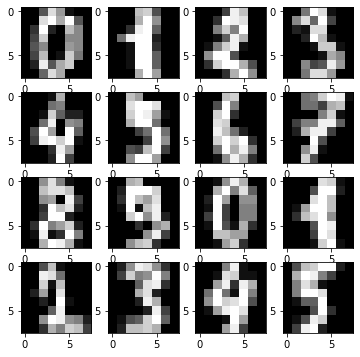

In [5]:
plt.figure(figsize=(6, 6))

for i, image in enumerate(digits.images[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [6]:
x = np.array([t for t, l in zip(x_train, y_train) if l in (0, 1)])

x.shape, x.max()

((360, 8, 8), 16.0)

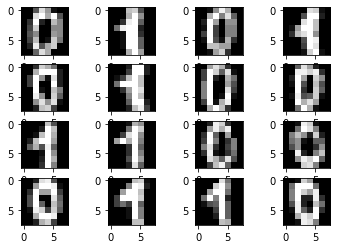

In [7]:
for i, image in enumerate(x[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [8]:
x = x.reshape(x.shape[0], 8, 8, 1).astype('float32')
x = (x - 8) / 8
#x

### Classical GAN

In [10]:
'''
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x)

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')
'''

"\nclass generator():\n\n    def __init__(self, gen_init_layer_size, z_dim):\n\n        super(generator, self).__init__()\n        self.gen_init_layer_size = gen_init_layer_size\n        self.z_dim = z_dim\n        self.gen_weight = RandomNormal(mean=0., stddev=1.0)\n        self.input = Input(shape=self.z_dim)\n        \n\n    def build_gen(self):\n\n        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, \n                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        \n        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)\n        x = BatchNorm

In [11]:
'''
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  
'''

"\nclass discriminator():\n    def __init__(self, disc_input_shape):\n        \n        super(discriminator, self).__init__() \n        self.disc_input_shape = disc_input_shape\n        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) \n        self.input = Input(shape=self.disc_input_shape)    \n              \n\n    def build_disc(self):\n        \n        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Flatten()(x)\n        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)\n\n        output = x\n\n        return Model(self.input, output, name = 'Discriminator_Network')  \n"

In [12]:
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x) 

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')

Model: "Generator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 128)        51200     
 nspose)                                         

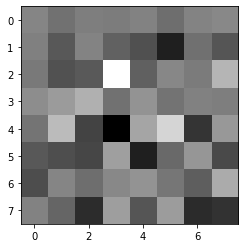

In [13]:
# Defining generator network
z_noise = tf.random.normal([6, z_dim])
gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
gen_net = gen.build_gen()
generated_image = gen_net(z_noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
gen_net.summary()

In [14]:
#generated_image

In [17]:
#gen_net.trainable_variables

In [18]:
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1)(x)#, kernel_initializer = self.disc_weight)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  

In [19]:
# Defining discriminator network
disc = discriminator(disc_input_shape = disc_input_shape)
disc_net = disc.build_disc()

a = x_train[0]
a = tf.expand_dims(a, axis = 0)
print(disc_net(a))

disc_net.summary()

tf.Tensor([[-0.44499397]], shape=(1, 1), dtype=float32)
Model: "Discriminator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 128)         0         
                                                       

In [20]:
#disc_net.trainable_weights

In [21]:
class Trainer():

    def __init__(self, x_train, gen_net, disc_net, gen_init_layer_size, z_dim, disc_input_shape, batch_size, writer, log_dir, logging = True):
        super(Trainer, self).__init__()
        self.x_train = x_train
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.disc_input_shape = disc_input_shape
        self.gen_opt = tf.keras.optimizers.Adam(1e-4)
        self.disc_opt = tf.keras.optimizers.Adam(1e-4) 
        self.batch_size = batch_size      
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
        self.gen_net = gen_net 
        self.disc_net = disc_net  
        self.writer = writer  
        self.logging= logging  
        self.log_dir = log_dir

        self.g_loss = []
        self.d_loss = []
    
    def gen_loss(self, fake_out):
        return self.loss(tf.ones_like(fake_out), fake_out)


    def disc_loss(self, img, fake_out):

        real_loss = self.loss(tf.ones_like(img), img)
        fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)

        total_loss = real_loss + fake_loss
        return total_loss   


    def generate_and_save_images(self, model, epoch, test_input):
        
        predictions = model(test_input, training=False)

        plt.figure(figsize=(8, 8))

        for i, image in enumerate(predictions, 1):
            try:
                plt.subplot(4, 4, i)
                plt.imshow(image[:, :, 0], cmap='gray')
            except ValueError:
                break       
        
        plt.savefig(self.log_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


    def train_step(self, image):

        noise = tf.random.normal([self.batch_size, self.z_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.gen_net(noise, training=True)

            real_out = self.disc_net(image, training = True)
            fake_out = self.disc_net(generated_images, training = True)

            gen_loss = self.gen_loss(fake_out)
            disc_loss = self.disc_loss(real_out, fake_out)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen_net.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_of_generator, self.gen_net.trainable_variables))
        self.disc_opt.apply_gradients(zip(gradients_of_discriminator, self.disc_net.trainable_variables))
            
        return gen_loss, disc_loss


    def learn(self, epochs):

        for epoch in range(epochs):

            print(f'EPOCH {epoch+1}')

            i = 0

            for j, batch_img in enumerate(self.x_train):

                gl, dl = self.train_step(batch_img)                

                i += 1

                self.g_loss.append(gl)
                
                self.d_loss.append(dl)

                with self.writer.as_default():
                    # save for tensorboard
                    tf.summary.scalar('Generator loss', data=gl, step=epoch* len(self.x_train) + j)
                    tf.summary.scalar('Discriminator loss', data=dl, step=epoch* len(self.x_train) + j)

                # log the reward with mlflow
                if self.logging:
                    mlflow.log_metric('Generator loss', gl, step=epoch* len(self.x_train) + j)
                    mlflow.log_metric('Discriminator loss', dl, step=epoch* len(self.x_train) + j)


            # produce images 
            display.clear_output(wait=True)
            self.generate_and_save_images(self.gen_net, epoch + 1, tf.random.normal([self.batch_size, self.z_dim]))  

            # save model with tensorflow
            if self.logging:            
                with self.writer.as_default():
                    tf.saved_model.save(self.gen_net, self.log_dir + f'generator_network')
                    tf.saved_model.save(self.disc_net, self.log_dir + f'discriminator_network')       
            
        
        # print(len(self.g_loss))
        # plt.figure(figsize=(15, 8))
        # plt.plot(np.arange(len(self.g_loss)), self.g_loss, color = 'Red', label = 'Generator Loss')
        # plt.plot(np.arange(len(self.d_loss)), self.d_loss, color = 'Blue', label = 'Discriminator Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend(loc = 'upper right')
        # plt.show()

## Training

In [22]:
z_dim = 2
batch_size = 4
buffer_size = 360
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
epochs = 700

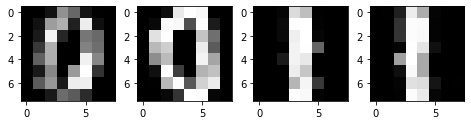

INFO:tensorflow:Assets written to: logs/GAN/20221221-143649/generator_network/assets
INFO:tensorflow:Assets written to: logs/GAN/20221221-143649/discriminator_network/assets


2022/12/21 15:37:52 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...


Saving models in mlflow...


2022/12/21 15:37:53 INFO mlflow.tensorflow: Validation succeeded!
/home/ludoboz/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2022/12/21 15:37:55 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...
2022/12/21 15:37:56 INFO mlflow.tensorflow: Validation succeeded!


In [23]:
# mlflow experiment settings
client = MlflowClient()
experiments = client.list_experiments()
experiment_name = 'Classical GAN'
#experiment_id = client.create_experiment(experiment_name)
#client.set_experiment_tag(experiment_id, 'GAN', 'GM')
print('Setting up experiment')
experiment = client.get_experiment_by_name(experiment_name)
experiment = mlflow.set_experiment(experiment_name=experiment_name)
experiment_id = experiment.experiment_id
run_name = 'Run'
i=0

with mlflow.start_run(run_name=run_name):
    # setting up generator and actor networks
    gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
    gen_net = gen.build_gen()
    disc = discriminator(disc_input_shape = disc_input_shape)
    disc_net = disc.build_disc()

    # starting mlflow run
    with mlflow.start_run(run_name=f'{run_name}_{i}', nested=True) as run:
        
        # training
        trainer = Trainer(x_train = train_dataset, gen_net = gen_net, disc_net = disc_net, gen_init_layer_size = gen_init_layer_size, z_dim = z_dim, 
                          disc_input_shape = disc_input_shape, batch_size = batch_size, writer = summary_writer, log_dir = log_dir)

        #%tensorboard --logdir logs/

        trainer.learn(epochs)
        
        # log and save the model in mlflow
        print('Saving models in mlflow...')
        models = ['generator_network', 'discriminator_network']
        artifact_path = f'mlruns/{experiment_id}/{run.info.run_id}/'
        for m in models:
            mlflow.tensorflow.save_model(tf_saved_model_dir = log_dir + m,
                                         tf_meta_graph_tags = None,
                                         tf_signature_def_key = "serving_default",
                                         path = artifact_path + "artifacts/" + m) 
    i+=1

### GIF

In [24]:
fp_in = "path/image_at_epoch_*.png"
fp_out = "path/GAN.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=150, loop=0)

StopIteration: 